# Installations and Mounting Drives

In [ ]:
! pip install chart_studio

     |████████████████████████████████| 64 kB 1.9 MB/s 


In [ ]:
import pandas as pd
import itertools
import spacy
import numpy as np
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objects as go
import re
import itertools
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas(desc="progress bar")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
pd.reset_option('all')
pd.set_option('display.max_colwidth', None)


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/usr/local/lib/python3.7/dist-packages/pandas/_config/config.py:622: FutureWarning:


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.




## Mount Drives

In [ ]:
# mount google drive into colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# authenticate to BigQuery
from google.colab import auth
auth.authenticate_user()

project_id = 'dfg-cohrv-314114'

# Import Crosswalks

## Company Tickers Dataframe

In [ ]:
# import sics company name - ticker csv
df_ticker = pd.read_csv('drive/MyDrive/Rights Colab JT/Datasets/sasb_label_20210128/sics_2021_03_01_US_ONLY.csv', usecols=["company_ticker", "company_name"])
df_ticker.head()

,company_ticker,company_name
0,EEIG,024 Pharma Inc
1,TXG,10X Genomics Inc
2,YI,111 Inc
3,PIH,"1347 Property Insurance Holdings, Inc."
4,ONCP,141 Capital Inc


In [ ]:
len(df_ticker)

16794

## Industry Descriptions Dataframe

In [ ]:
# load and join industry descriptions
df_ind_desc = pd.read_csv('drive/MyDrive/Rights Colab JT/Datasets/sasb_label_20210128/industry.csv')
df_ind_desc = df_ind_desc[['INDUSTRY_ID', 'INDUSTRY_NAME']]
df_ind_desc.columns = ['primary_industry_id', 'primary_industry_desc']

# replace the names with short names
df_ind_desc = df_ind_desc.replace("Electric Utilities & Power Generators", "Elec Utils & Power Gen")
df_ind_desc = df_ind_desc.replace("Electronic Manufacturing Services & Original Design Manufacturing", "Elec Manuf Svcs & Orig Des Manuf")
df_ind_desc = df_ind_desc.replace("Engineering & Construction Services", "Engr & Construction Svcs")
df_ind_desc = df_ind_desc.replace("Oil & Gas – Exploration & Production", "Oil & Gas – Expl & Prod")
df_ind_desc = df_ind_desc.replace("Professional & Commercial Services", "Prof & Comm Svcs")
df_ind_desc = df_ind_desc.replace("Wind Technology & Project Developers", "Wind Tech & Proj Dev")
df_ind_desc = df_ind_desc.replace("Multiline and Specialty Retailers & Distributors", "Multiline and Splty Rtl & Dists")
df_ind_desc = df_ind_desc.replace("Solar Technology & Project Developers", "Solar Tech & Proj Dev")
df_ind_desc.head()

,primary_industry_id,primary_industry_desc
0,CG-AA,"Apparel, Accessories & Footwear"
1,CG-AM,Appliance Manufacturing
2,CG-BF,Building Products & Furnishings
3,CG-EC,E-commerce
4,CG-HP,Household & Personal Products


In [ ]:
len(df_ind_desc)

77

## 10-K SIC Dataframe

In [ ]:
df_10ks_sics = pd.read_csv('drive/MyDrive/Rights Colab JT/Datasets/10k_clean_text/_0.0 downloaded/usable_10ks_with_sics.csv')
df_10ks_sics['year'] = df_10ks_sics['fy'].astype('str').str[:4]

df_10ks_sics.head()

,filename,filepath,ticker,type,fy,doc_id,id,company_ticker,company_name,isin,naics_code,country,exchange,market_cap,market_cap_category,revenue,primary_industry_id,secondary_industry_id,tertiary_industry_id,is_active,last_modified_date,scope,ticker_display,year
0,STAG_10-K_20121231_0001047469-13-002284.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2013Q1/STAG_10-K_20121231_0001047469-13-002284.txt,STAG,10-K,20121231,0001047469-13-002284.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2012
1,STAG_10-K_20131231_0001047469-14-001398.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2014Q1/STAG_10-K_20131231_0001047469-14-001398.txt,STAG,10-K,20131231,0001047469-14-001398.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2013
2,STAG_10-K_20141231_0001558370-15-000135.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2015Q1/STAG_10-K_20141231_0001558370-15-000135.txt,STAG,10-K,20141231,0001558370-15-000135.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2014
3,STAG_10-K_20151231_0001479094-16-000006.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2016Q1/STAG_10-K_20151231_0001479094-16-000006.txt,STAG,10-K,20151231,0001479094-16-000006.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2015
4,STAG_10-K_20161231_0001479094-17-000005.txt,/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/2017Q1/STAG_10-K_20161231_0001479094-17-000005.txt,STAG,10-K,20161231,0001479094-17-000005.txt,135671,STAG,"Stag Industrial, Inc.",US85254J1025,NaN,US,New York,3.575124e+09,Medium Cap,NaN,IF-RE,NaN,NaN,Y,2019-12-13 00:08:25,US,STAG,2016


In [ ]:
df_10ks_sics.columns

Index(['filename', 'filepath', 'ticker', 'type', 'fy', 'doc_id', 'id',
       'company_ticker', 'company_name', 'isin', 'naics_code', 'country',
       'exchange', 'market_cap', 'market_cap_category', 'revenue',
       'primary_industry_id', 'secondary_industry_id', 'tertiary_industry_id',
       'is_active', 'last_modified_date', 'scope', 'ticker_display', 'year'],
      dtype='object')

In [ ]:
len(df_10ks_sics)

35230

## Industry-level Ticker Counts

In [ ]:
# calculate and join industry-level ticker counts
df_ind_total = df_10ks_sics.groupby(['year', 'primary_industry_id'])\
                .agg({'ticker_display': pd.Series.nunique}).reset_index()
df_ind_total.columns = ['year', 'primary_industry_id', 'ind_tot_tkr']

# dataframe that contains industries aggregated by year with the total occurances of the terms in the heuristics
df_ind_total.head()

,year,primary_industry_id,ind_tot_tkr
0,2000,CG-MR,1
1,2001,CG-MR,1
2,2001,TC-HW,1
3,2002,CG-MR,1
4,2002,TC-TL,1


In [ ]:
len(df_ind_total)

762

# Gathering Labor Practices Practice/Risk Terms

In [ ]:
import re

# FIND SUPPLY CHAIN MGMT-RELATED TERMS ONLY BELOW

START_REGEX = '(?<![^ .,?!;])'


def attach_regex_to_beginning_of_terms(terms_lst, regex=START_REGEX):
    if regex == '(?<![^ .,?!;])':
        return [regex + term for term in terms_lst]


def create_comprehensive_term_regex_cleaning_dict(
        term_type, category_to_term_mapping_SIMPLE, category_to_term_mapping_COMPLEX):
    # term_type_dict = {'term_type_cat': {'clean term': 'regex_lst': {['fmt1', 'fmt2']}, 'extra_cleaning': True}}
    term_type_regexes_cleaning = {}
    for term_cat, term_lst in category_to_term_mapping_SIMPLE.items():

        # Create dictionary for term type category
        if term_cat not in term_type_regexes_cleaning:
            term_type_regexes_cleaning[term_cat] = dict()

        # Variable for new category dict for `term_type_regexes_cleaning`
        term_cat_dict = term_type_regexes_cleaning[term_cat]

        term_cat_SIMPLE_lst = category_to_term_mapping_SIMPLE[term_cat]
        for term_SIMPLE in term_cat_SIMPLE_lst:
            # term_regex = re.compile(attach_regex_to_beginning_of_terms([term_SIMPLE])[0])
            term_regex_str_lst = attach_regex_to_beginning_of_terms([term_SIMPLE])
            # term_cat_dict[term_SIMPLE] = {'regex_lst': [re.compile(START_REGEX + regex) for regex in term_regex_str_lst], 'extra_cleaning': False, 'terms_to_remove': []}  # TODO: Create detailed function for examples of the term to ignore, wich will have extra_cleaning=True
            term_cat_dict[term_SIMPLE] = {'regex_lst': [re.compile(regex) for regex in term_regex_str_lst],
                                          'extra_cleaning': False, 'terms_to_remove': [],
                                          'context_words': []}  # TODO: Create detailed function for examples of the term to ignore, wich will have extra_cleaning=True

        term_cat_COMPLEX = category_to_term_mapping_COMPLEX[term_cat]
        for term_clean_COMPLEX, term_COMPLEX_regex_list in term_cat_COMPLEX.items():
            # term_regex_str_lst = attach_regex_to_beginning_of_terms(term_COMPLEX_dict)
            term_cat_dict[term_clean_COMPLEX] = {'regex_lst': [re.compile(regex) for regex in term_COMPLEX_regex_list],
                                                 'extra_cleaning': False, 'terms_to_remove': [], 'context_words': []}

        term_type_regexes_cleaning[term_cat] = term_cat_dict

    return term_type_regexes_cleaning

In [ ]:
# labor-related risk terms
risk_category_to_term_mapping_SIMPLE = {
    'Worker-Protest': ['strike', 'sit-in', 'operational disruption',
                       'protest'], #, 'injury'],
    "Modern-Slavery": ['modern slavery', 'debt bondage', 'human traffic'],

    'Consumer-Protest': ['boycott', 'protest', 'social license'],

    'Operational-Costs': ['operational disruption', 'operating cost', 'delay',
                          'disruption'],

    'Financial-Loss': ['sanction', 'reimburse', 'restitution', 'fine',
                       'compensation', 'penalt', 'bankrupt', 'liabl', 'loss', 'lost'],

    'Legal-Risk': ['lawsuit', 'litigation', 'impoundment', 'detain',
                   'penalt', 'sanction', 'court'],

    'Reputational-Damage': ['brand damage', 'monetary damage',
                            'reputation', 'brand recognition',
                            'social license',
                            'decreased trust',
                            'decreased innovation',
                            'lost opportunit',
                            ],

    "Remedy": ['reimburse', 'compensation', 'divest', 'restitution'],

    'Other': ['alleg', 'accus', 'exploit', 'expose', 'investigat',
              'police', 'enforcement', 'security force', 'inspection', 'inspector',
              ],

    'Other-RK': ['scandal', 'government action', 'share price', 'share value',
                 'investment',
                 # 'sales'
                 ]
}
risk_category_to_term_mapping_COMPLEX = {
    'Worker-Protest': {'walkout': attach_regex_to_beginning_of_terms(['walk[- ]?out'])},
    "Modern-Slavery": {
        'forced labor': attach_regex_to_beginning_of_terms(['(forced|slave) labo[u]?r']),
        'child labor': attach_regex_to_beginning_of_terms(['child labo[u]?r', 'child slave']),
    },
    'Consumer-Protest': {'social license': attach_regex_to_beginning_of_terms(['social licen[cs]e'])},
    'Operational-Costs': {
        'withhold release order': attach_regex_to_beginning_of_terms(['withhold release order', 'wro[s]?\W']),
        'block import': attach_regex_to_beginning_of_terms(['block(.*)import', 'ban(.*)import', 'import(.*)ban',
                                                            'prohibit(.*)import', 'import(.*)prohibit',
                                                            'block(.*)entry', 'entry(.*)block',
                                                            'seiz(.*)product', 'product(.*)seiz']), },
    'Financial-Loss': {'pay damages': attach_regex_to_beginning_of_terms(['pay(.*)damage']),
                       'seizure of assets': attach_regex_to_beginning_of_terms(['seiz(.*)asset']), },
    'Legal-Risk': {},
    'Reputational-Damage': {
        'workplace shutdown': attach_regex_to_beginning_of_terms(['workplace shutdown', 'shutdown']),
        'social license': attach_regex_to_beginning_of_terms(['social licen[cs]e'])},
    "Remedy": {},
    'Other': {},
    'Other-RK': {'negative return': attach_regex_to_beginning_of_terms(['negative(.*)return'])}
}

In [ ]:
# practice terms
practice_category_to_term_mapping_SIMPLE = {
    'Wages': [
        'wage',
        'wage theft', 'stolen wage',
        'living wage'],
    'Immigrants': [],
    'Precarious-Work': [
        'precarity',
        'gig work',
        'alternative work',
        'alternate work',
        'contingent work',
        # 'migrant',
        'informal work',
        'casual work',
        'hazardous work'
    ],
    'Mdrn-Slav-Risk': [  # 'broker', 'agent',
        'confinement', 'document retention',
        'restriction of movement',
        'delayed wage',
        'pay manipulation',
        'punishment', 'poor food', #'retaliat',
        'sexual violence', 'sexual harassment', 'sex abuse',
        'deprivation',
        'unpaid wage',
        'delayed payment', 'wage violation'
    ],

    'Work-Conditions': [
        # 'reprisal', # reprisals
        # 'health and safety',
        # 'lockout',
        'employee morale',
        'freedom of association',
        'collective bargaining',
        'work stoppage',
        'hotline',
        'worker retention'
    ],
    'Good-Practices': ['code of conduct', 'due diligence',
                       'ethical recruit',  # ethical recruitment
                       'handbook',  # supplier handbook
                       'supplier remediation',
                       'social audit',
                       # 'risk assessment',
                       'worker engagement',
                       #'transparency', 
                       'traceability', #'visibility',
                       'supply chain map',
                       'timely payments',
                       'fair terms of payment',  # Added 11/28
                       # 'training',  # TODO: GET BACK TO THIS AFTER THE FALL # Added 11/28
                       # 'contract',  # TODO: GET BACK TO THIS AFTER THE FALL # Added 11/28
                       'union', 'worker committee'
                       ],
    'Neutral-Practices': [
        # 'sourcing',
        'outsourc',  # Kept based on Joanne's feedback
        # 'raw material', # raw materials,
        # 'subcontracting',
        'small-holder supply chain'#,
        # 'overtime',
        #'demand volatility',
    ],
    'Negative-Practices': [
        # 'conflict',
        #'order delay',
        #'lead time',  # previously 'short lead time'
        'unplanned shipment',
        #'corruption',
        # 'fraud',
        'quota system', 'delayed payment',
        'weak governance', 'wage violation',
        'informal supply chain', 'last-minute order modification',
        'unfair timing demand'#, 'pricing pressure',
        #'poor forecasting',
        #'cancellation'  # Added 11/28
    ],
    'Other': ['labor rights violation',
              'worker representation'#, 'representation',  # Added 11/28
              #'purchasing', 'purchasing practices',  # Added 11/28
              ]
}

practice_category_to_term_mapping_COMPLEX = {
    'Wages': {
        # 'pricing': attach_regex_to_beginning_of_terms(['pricing', 'price']),
        'low wages': attach_regex_to_beginning_of_terms(['low wage', 'poverty-level wage']),
        'underpay': attach_regex_to_beginning_of_terms(['underpay (worker|employee|wage)', 'underpaid (worker|employee|wage)', '(inadequate|reduced|no) pay'])},
    'Immigrants': {
        'visa worker': attach_regex_to_beginning_of_terms(['visa work', 'work(er)? visa'])
    },
    'Precarious-Work': {
        'temporary worker-employee': attach_regex_to_beginning_of_terms(['temporary(.*)work', 'temporary(.*)employ',
                                                                         'temporary(.*)contract',
                                                                         'non(- )?permanent contract']),
        'contract labor': attach_regex_to_beginning_of_terms(['contract labo[u]?r', 'contract work']),
        'precarious work': attach_regex_to_beginning_of_terms(['precarious work', 'precarious job']), },
    'Mdrn-Slav-Risk': {
        # 'third party': attach_regex_to_beginning_of_terms(['third[- ]party'])
        'coercive labor': attach_regex_to_beginning_of_terms(['coercive labo[u]?r']),
        'prison labor': attach_regex_to_beginning_of_terms(['prison labo[u]?r']),
        'recruitment fee': attach_regex_to_beginning_of_terms(['recruitment(.*)fee']),
        'withhold wage': attach_regex_to_beginning_of_terms(['withh[oe]ld(ing)? wage']),
        'passport retention': attach_regex_to_beginning_of_terms(
            ['passport retention', 'retention of passport', 'withh[oe]ld(ing)? passport'])
    },
    'Work-Conditions': {'collective bargaining agreement': attach_regex_to_beginning_of_terms(
        ['collective bargaining agreement', 'cba[s]?\W']),
                        # TODO: get back to turnover
                        'turnover': attach_regex_to_beginning_of_terms(
                            ['high turnover', 'worker turnover', 'employee turnover', 'turnover rate',
                             'voluntary turnover',  # because of START_REGEX, "involuntary turnover" is automatically left out
                             'quit[s]? rate', 'rate of quit'
                             ]
                        ),
                        'unsafe conditions': attach_regex_to_beginning_of_terms(
                            ['unsafe(.*)condition', 'hazard(.*)condition', 'working conditions']),
                             #'deteriorating(.*)condition']),
                        'grievance mechanism': attach_regex_to_beginning_of_terms(
                            ['grievance mechanism', 'grievance system'])},
    'Good-Practices': {'code of conduct negative': attach_regex_to_beginning_of_terms(
        ['code of conduct(.*)breach', 'breach(.*)code of conduct',
         'violat(.*)code of conduct', 'code of conduct(.*)violat',
         'non[- ]?compliance(.*)code of conduct', 'code of conduct(.*)non[- ]?compliance',
         'break(.*)code of conduct',
         'broken(.*)code of conduct', 'code of conduct(.*)broken',
         'fail(.*)code of conduct']),
        'responsible exit': attach_regex_to_beginning_of_terms(['responsibl[e|y](.*)exit', 'exit(.*)responsibl[e|y]'])
                       },
    'Neutral-Practices': {#'corrective action': attach_regex_to_beginning_of_terms(
        #['corrective(.*)action', 
        # 'corrective(.*)plan', 'corrective(.*)measure'])
    },
    'Negative-Practices': {
        # 'piece work': attach_regex_to_beginning_of_terms(['piece work', 'piece[- ]rate']),
        'production target': attach_regex_to_beginning_of_terms(['production target', 'production quota', 'strict quota']),
        'hour violation': attach_regex_to_beginning_of_terms(['hour (law )?violation']),
        #'canceled order': attach_regex_to_beginning_of_terms(['cancel([l]?(ed)|([l]?ing))? order',
                                                              #'order cancellation']),  # <- Added 11/28
        'overtime NEGATIVE': attach_regex_to_beginning_of_terms(
            ['(forced|unpaid|chronic|mandatory|illegal) overtime', 'long hours', 'overwork', 'off the clock']),
        'lead time NEGATIVE': attach_regex_to_beginning_of_terms(['short lead time', 'inadequate lead time']),
        'irresponsible exit': attach_regex_to_beginning_of_terms(['irresponsibl[e|y](.*)exit', 'exit(.*)irresponsibl[e|y]'])
    },
    'Other': {
        'ringfence labor': attach_regex_to_beginning_of_terms(['ringfence labo[u]?r']),  # Added 11/28
        'labor costs': attach_regex_to_beginning_of_terms(['labo[u]?r cost']),  # Added 11/28
    }
}

# supplier relationship terms
supplier_relship_category_to_term_mapping_SIMPLE = {
    'Core': ['supplier', 'sourcing', 'manufactur', 'factory', 'mining', 'raw material', 'workshop', 'warehouse']
}

supplier_relship_category_to_term_mapping_COMPLEX = {
    'Core': {'sweatshop': attach_regex_to_beginning_of_terms(['sweatshop', 'sweat factory'])}
}

# Get dictionaries of practice/risk/supplier terms
practice_terms_regex_dict = create_comprehensive_term_regex_cleaning_dict(
    term_type='practice',
    category_to_term_mapping_SIMPLE=practice_category_to_term_mapping_SIMPLE,
    category_to_term_mapping_COMPLEX=practice_category_to_term_mapping_COMPLEX)

risk_terms_regex_dict = create_comprehensive_term_regex_cleaning_dict(
    term_type='risk',
    category_to_term_mapping_SIMPLE=risk_category_to_term_mapping_SIMPLE,
    category_to_term_mapping_COMPLEX=risk_category_to_term_mapping_COMPLEX)

supplier_relship_regex_dict = create_comprehensive_term_regex_cleaning_dict(
    term_type='supplier-relship',
    category_to_term_mapping_SIMPLE=supplier_relship_category_to_term_mapping_SIMPLE,
    category_to_term_mapping_COMPLEX=supplier_relship_category_to_term_mapping_COMPLEX)

# Adding extra cleaning terms here (during processing, any mentions of
# practice/risk terms in the irrelevant contexts below will be excluded)

# agent
# practice_terms_regex_dict['Mdrn-Slav-Risk']['agent']['extra_cleaning'] = True
# practice_terms_regex_dict['Mdrn-Slav-Risk']['agent']['terms_to_remove'] = ['recruitment agent']

# third party
# practice_terms_regex_dict['Mdrn-Slav-Risk']['third party']['extra_cleaning'] = True
# practice_terms_regex_dict['Mdrn-Slav-Risk']['third party']['terms_to_remove'] = ['independent third party']

# union
practice_terms_regex_dict['Good-Practices']['union']['extra_cleaning'] = True
practice_terms_regex_dict['Good-Practices']['union']['terms_to_remove'] = ['european union', 'customs union']

practice_terms_regex_dict['Wages']['underpay']['extra_cleaning'] = True
practice_terms_regex_dict['Wages']['underpay']['terms_to_remove'] = ['underpaid duties']

#practice_terms_regex_dict['Negative-Practices']['corruption']['extra_cleaning'] = True
#practice_terms_regex_dict['Negative-Practices']['corruption']['terms_to_remove'] = ['data corruption'] # check

# strike
risk_terms_regex_dict['Worker-Protest']['strike']['extra_cleaning'] = True
risk_terms_regex_dict['Worker-Protest']['strike']['terms_to_remove'] = ["disaster(s\b|\b) strike", 'strike deal',
                                                                        'weather strike', 'bridge strike',
                                                                        'joint strike fighter', 'strike price']
# pricing pressure

# practice_terms_regex_dict['Negative-Practices']['pricing pressure']['context_words'] = ['supplier', 'factory',
                                                                                        #'manufactur', 'warehouse',
                                                                                        #'workshop']
# contract
# practice_terms_regex_dict['Good-Practices']['contract']['context_words'] = ['supplier']

risk_terms_regex_dict['Worker-Protest']['strike']['context_words'] = ['labor','union','contractor','worker','employee']



# all supplier context words:
relationship_words = ['relationship', 'purchaser', 'order', 'lead time',
                      'cancel([l]?(ed)|([l]?ing))? order', 'cancellation',
                      'buyer', 'outsourc', 'subcontract']
for core_term in supplier_relship_category_to_term_mapping_SIMPLE['Core']:
    supplier_relship_regex_dict['Core'][core_term]['context_words'] = relationship_words
for core_term in supplier_relship_category_to_term_mapping_COMPLEX['Core']:
    supplier_relship_regex_dict['Core'][core_term]['context_words'] = relationship_words

# Connecting to BigQuery

In [ ]:
# count num 10-K paragraphs
num_pars = pd.io.gbq.read_gbq(
  '''
  SELECT COUNT(*)
  FROM `dfg_cohrv.10ks_para_sics`
  '''
, project_id=project_id)

In [ ]:
pars = num_pars.iloc[0,0]
pars

16536696

In [ ]:
# retrieve results
df_result = pd.io.gbq.read_gbq(
  '''
  SELECT *
  FROM `dfg_cohrv.10ks_para_sics`
  WHERE rand() < 0.01
  '''
, project_id=project_id)

In [ ]:
df_result.head()

,id,ticker_display,primary_industry_id,text
0,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt_20,CTHR,CG-AA,Our success and our ability to compete successfully depend in part upon our proprietary technology. In addition to our remaining international patents we rely on trade secret laws and employee consultant and customer confidentiality agreements to protect certain aspects of our technology. We currently are not subject to any claims that our products or processes infringe on the proprietary rights of third parties. At the present time we are also dependent on Cree's technology for the production of SiC crystals.
1,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt_39,CTHR,CG-AA,The worldwide market for large uncut high-quality natural diamonds is significantly consolidated and controlled by DeBeers (headquartered in South Africa) Alrosa (Russia) Rio Tinto (Australia) and BHP (Canada). These companies have a major impact on the worldwide supply and pricing of natural diamonds at both the wholesale and retail levels. Diamond producers may undertake additional marketing or other activities designed to protect the diamond jewelry market against sales erosion from consumer acceptance of moissanite jewels.
2,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt_226,CTHR,CG-AA,Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price
3,2016Q1_CHS_10-K_20160130_0000897429-16-000311.txt_62,CHS,CG-AA,Although we have adopted our Terms of Commitment to Ethical Sourcing and use the services of third party audit firms to monitor compliance with these terms we do not have complete control over the labor practices of our independent suppliers. As a result some of our suppliers may not be in complete compliance with our guidelines at all times. The violation of labor or other laws by any of our key independent suppliers or the divergence of an independent supplier's labor practices from those generally accepted by us as ethical could interrupt or otherwise disrupt the shipment of finished merchandise or damage our reputation.
4,2016Q1_CBKC_10-K_20160130_0001558370-16-004236.txt_17,CBKC,CG-AA,Our new store growth strategy will be focused primarily on outlets. These stores enable us to expand our customer reach to new geographies and heighten brand awareness. Our outlet stores contain a mixture of core merchandise made-for-outlet merchandise and clearance merchandise. The made-for-outlet product carries a higher margin than the clearance items from our retail store base. We regularly review the appropriate ratio of made-for-outlet and clearance merchandise Table of Contents for our outlets and adjust that ratio as appropriate. We see an ongoing growth opportunity in our outlet business and believe we can successfully operate approximately 100 outlet locations.


# Reading Through 10-K's

## Finding All Unique Industries and Companies

In [ ]:
industry_list = df_result['primary_industry_id'].unique()

print(industry_list)

['CG-AA' 'CG-AM' 'CG-BF' 'CG-HP' 'CG-MR' 'EM-CO' 'EM-EP' 'EM-IS' 'EM-MD'
 'EM-MM' 'EM-RM' 'EM-SV' 'FB-AB' 'FB-AG' 'FB-FR' 'FB-NB' 'FB-RN' 'FN-AC'
 'FN-CB' 'FN-CF' 'FN-EX' 'FN-IB' 'FN-IN' 'FN-MF' 'HC-BP' 'HC-DY' 'HC-MC'
 'HC-MS' 'IF-EN' 'IF-EU' 'IF-GU' 'IF-HB' 'IF-RE' 'IF-WM' 'IF-WU' 'RR-FC'
 'RR-FM' 'RR-PP' 'RR-WT' 'RT-AE' 'RT-CH' 'RT-CP' 'RT-EE' 'RT-IG' 'SV-AD'
 'SV-CA' 'SV-ED' 'SV-HL' 'SV-LF' 'SV-ME' 'SV-PS' 'TC-ES' 'TC-HW' 'TC-IM'
 'TC-SC' 'TC-SI' 'TC-TL' 'TR-AL' 'TR-AP' 'TR-RA' 'TR-RO' 'EM-CM' 'FB-MP'
 'FB-TB' 'HC-DI' 'IF-RS' 'RR-ST' 'TR-AF' 'TR-AU' 'TR-CL' 'TR-MT' 'FB-PF'
 'RR-BI' 'CG-EC' 'CG-TS' 'HC-DR' 'TR-CR']


In [ ]:
company_list = df_result['ticker_display'].unique()

print(company_list)

['CTHR' 'CHS' 'CBKC' ... 'KDCE' 'TLDN' 'GMPW']


# Breakdown of 10-K's by Document, Company, Industry

In [ ]:
# example of how to access 10-K's for specific companies
df_result[df_result['ticker_display'] == company_list[0]]

,id,ticker_display,primary_industry_id,text
0,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt_20,CTHR,CG-AA,Our success and our ability to compete successfully depend in part upon our proprietary technology. In addition to our remaining international patents we rely on trade secret laws and employee consultant and customer confidentiality agreements to protect certain aspects of our technology. We currently are not subject to any claims that our products or processes infringe on the proprietary rights of third parties. At the present time we are also dependent on Cree's technology for the production of SiC crystals.
1,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt_39,CTHR,CG-AA,The worldwide market for large uncut high-quality natural diamonds is significantly consolidated and controlled by DeBeers (headquartered in South Africa) Alrosa (Russia) Rio Tinto (Australia) and BHP (Canada). These companies have a major impact on the worldwide supply and pricing of natural diamonds at both the wholesale and retail levels. Diamond producers may undertake additional marketing or other activities designed to protect the diamond jewelry market against sales erosion from consumer acceptance of moissanite jewels.
2,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt_226,CTHR,CG-AA,Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price
23046,2018Q1_CTHR_10-K_20171231_0001140361-18-012655.txt_63,CTHR,CG-AA,Our primary source of working capital is cash on hand and cash generated by operations. Because we have a quarterly minimum purchase commitment under the Supply Agreement we may be required to purchase SiC materials in excess of our immediate needs from time to time which may result in inventories that are higher than we might otherwise maintain.
23047,2018Q1_CTHR_10-K_20171231_0001140361-18-012655.txt_81,CTHR,CG-AA,Our corporate information is accessible through our website at https://www.charlesandcolvard.com. We are not including the information contained on our website as a part of or incorporating it by reference into this Annual Report on Form 10-K. We make available free of charge access on our website to all reports we file with or furnish to the SEC including our Annual Reports on Form 10-K our Quarterly Reports on Form 10-Q our Current Reports on Form 8-K and amendments to these reports as soon as reasonably practicable after we electronically file such material with or furnish it to the SEC. A copy of this Annual Report on Form 10-K and our other reports are available without charge upon written request to Investor Relations Charles & Colvard Ltd. 170 Southport Drive Morrisville North Carolina 27560. Table of Contents
23048,2018Q1_CTHR_10-K_20171231_0001140361-18-012655.txt_284,CTHR,CG-AA,"Pursuant to the terms of the Purchase Agreement the Transferred Assets included among other things (i) an inventory credit usable towards certain inventory as of the Closing Date (ii) all existing marketing collateral for Direct's jewelry offered under the ""Lulu Avenue"" trademarks as of the Closing Date (iii) certain assigned contracts (iv) style advisor and customer lists and (v) all intellectual property rights owned by the Company and Direct and used solely in connection with the operation of Direct's direct-to-consumer home party business for the sale of fashion jewelry and related products and services in the U.S. excluding Lulu Avenue-related intellectual property. The inventory credit and an exclusive nontransferable license to use the Lulu Avenue-related intellectual property that was also granted to Yanbal on the Closing Date expired on July 31 2016. After the Closing Date the Company and Direct may no longer engage in the direct-to-consumer home party busines

Our new dataframe with a year attached to each sub 10-K:

In [ ]:
df_result['year'] = df_result['id'].str[:4]

In [ ]:
df_result['year'].unique()

array(['2016', '2013', '2018', '2014', '2015', '2017', '2019', '2020',
       '2021'], dtype=object)

In [ ]:
len(df_result)

165284

# Applying Indicators to 10-K's

In [ ]:
def get_labor_indicator_v2(row, labor_keywords):
    """Applying this heuristic to generate indicator for mentions of 
    at least 2 of the following labor-related keywords: 
    ['labo[u]r', 'wage', 'worker']. 
    (v1 included all words as well as "employee".) """
    cols = [f'{keyword}_ind' for keyword in labor_keywords]
    count_labor_term_inds_1 = 0
    for col in cols:
        if row[col] == 1:
            count_labor_term_inds_1 += 1
    if count_labor_term_inds_1 >= 2:
        return 1
    else:
        return 0

In [ ]:
labor_keywords = [r'labo[u]r', 'wage', 'worker']
covid_keywords = ['covid', 'coronavirus', 'pandemic']
pattern_covid = '|'.join(covid_keywords)

# Apply general labor practice-relevance heuristic
for keyword in labor_keywords:
    keyword_regex = re.compile(f'(?<![^ .,?!;]){keyword}')
    df_result[f'{keyword}_ind'] = np.where(df_result['text'].str.contains(keyword_regex), 1, 0)

df_result['labor_keyword_ind'] = df_result.apply(lambda row: get_labor_indicator_v2(row, labor_keywords), axis=1)
df_result['marked_labor_relevant_ind'] = df_result['labor_keyword_ind']

# Apply COVID-specific labor practice-relevance heuristic ONLY to articles marked as lp-relevant above
mask_marked_as_lp_relevant = (df_result['labor_keyword_ind'] == 1)
mask_mentions_covid = df_result['text'].str.contains(pattern_covid)

df_result['covid_and_labor_keyword_ind'] = np.where(mask_marked_as_lp_relevant & mask_mentions_covid, 1, 0)

# PRACTICE TERM INDICATORS CREATED HERE
term_type = 'practice'

for cat, cat_terms in practice_terms_regex_dict.items():
    for clean_term, term_dict in cat_terms.items():
        indicator_col_name = "{}_{}_{}".format(clean_term, term_type.upper(), cat)
        keyword_regexes = term_dict['regex_lst']
        df_result[indicator_col_name] = 0

        for keyword_regex_str in keyword_regexes:
            keyword_regex = re.compile(keyword_regex_str)
            df_result[indicator_col_name] = np.where(df_result['text'].str.contains(keyword_regex), 1, df_result[indicator_col_name])

        if term_dict['extra_cleaning']:
            pattern_terms_to_remove = re.compile('|'.join(term_dict['terms_to_remove']))
            df_result[indicator_col_name] = np.where(df_result['text'].str.contains(pattern_terms_to_remove), 0, df_result[indicator_col_name])

# RISK TERM INDICATORS CREATED HERE
term_type = 'risk'

for cat, cat_terms in risk_terms_regex_dict.items():
    for clean_term, term_dict in cat_terms.items():
        indicator_col_name = "{}_{}_{}".format(clean_term, term_type.upper(), cat)
        keyword_regexes = term_dict['regex_lst']
        df_result[indicator_col_name] = 0

        for keyword_regex_str in keyword_regexes:
            keyword_regex = re.compile(keyword_regex_str)
            df_result[indicator_col_name] = np.where(df_result['text'].str.contains(keyword_regex), 1, df_result[indicator_col_name])
        
        if term_dict['extra_cleaning']:
            pattern_terms_to_remove = re.compile('|'.join(term_dict['terms_to_remove']))
            df_result[indicator_col_name] = np.where(df_result['text'].str.contains(pattern_terms_to_remove), 0, df_result[indicator_col_name])

# SUPPLIER RELATIONSHIP TERM INDICATORS CREATED HERE
term_type = 'supplier_relship'

for cat, cat_terms in supplier_relship_regex_dict.items():
    for clean_term, term_dict in cat_terms.items():
        indicator_col_name = "{}_{}_{}".format(clean_term, term_type.upper(), cat)
        keyword_regexes = term_dict['regex_lst']
        df_result[indicator_col_name] = 0

        for keyword_regex_str in keyword_regexes:
            keyword_regex = re.compile(keyword_regex_str)
            df_result[indicator_col_name] = np.where(df_result['text'].str.contains(keyword_regex), 1, df_result[indicator_col_name])
        
        if term_dict['extra_cleaning']:
            pattern_terms_to_remove = re.compile('|'.join(term_dict['terms_to_remove']))
            df_result[indicator_col_name] = np.where(df_result['text'].str.contains(pattern_terms_to_remove), 0, df_result[indicator_col_name])


/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



# Practice/Risk Term Search in 10-K's

 ## Indicator for Either Practice OR Risk Term

In [ ]:
# Adding indicators of having any practice term or risk term, 
# to quickly identify events with co-occurrences of practice and risk terms

# indicator format: {term}_{PRACTICE/RISK}_{category}

all_cols = list(df_result.columns)
practice_term_cols = []
risk_term_cols = []
labor_risk_cols = []
supplier_relship_cols = []

for col in all_cols: 
    
    try:
        col_type = col.split('_')[1]
        cat = col.split('_')[2]
        if col_type == 'PRACTICE':
            practice_term_cols.append(col)
        elif col_type == 'RISK':
            risk_term_cols.append(col)
        else:
            supplier_relship_cols.append(col)
        if col_type == 'RISK' and (cat in ['Worker-Protest','Modern-Slavery']):
            labor_risk_cols.append(col)

    except:
        continue

df_result['ANY_PRACTICE_TERM'] = 0
for practice_term_col in practice_term_cols:
    df_result['ANY_PRACTICE_TERM'] = np.where(df_result[practice_term_col] == 1, 
                                                                    1, df_result['ANY_PRACTICE_TERM'])
    
df_result['ANY_RISK_TERM'] = 0
for risk_term_col in risk_term_cols:
    df_result['ANY_RISK_TERM'] = np.where(df_result[risk_term_col] == 1, 
                                                                    1, df_result['ANY_RISK_TERM'])

df_result['ANY_SUPP_RELSHIP_TERM'] = 0
for supplier_relship_col in supplier_relship_cols:
    df_result['ANY_SUPP_RELSHIP_TERM'] = np.where(df_result[supplier_relship_col] == 1, 
                                                                    1, df_result['ANY_SUPP_RELSHIP_TERM'])


df_result['ANY_LABOR_RISK_TERM'] = 0
for labor_risk_col in labor_risk_cols:
    df_result['ANY_LABOR_RISK_TERM'] = np.where(df_result[labor_risk_col] == 1, 
                                                                    1, df_result['ANY_LABOR_RISK_TERM'])
    
df_result['ANY_PRACTICE_AND_RISK'] = np.where((df_result['ANY_PRACTICE_TERM'] == 1) & (df_result['ANY_RISK_TERM'] == 1), 1, 0)
df_result['ANY_PRACTICE_OR_RISK'] = np.where((df_result['ANY_PRACTICE_TERM'] == 1) | (df_result['ANY_RISK_TERM'] == 1), 1, 0)

df_result['ANY_PRACTICE_AND_LABOR_RISK'] = np.where((df_result['ANY_PRACTICE_TERM'] == 1) & (df_result['ANY_LABOR_RISK_TERM'] == 1), 1, 0)
df_result['ANY_PRACTICE_OR_LABOR_RISK'] = np.where((df_result['ANY_PRACTICE_TERM'] == 1) | (df_result['ANY_LABOR_RISK_TERM'] == 1), 1, 0)

df_result['ANY_RISK_AND_marked_labor_relevant'] = np.where((df_result['marked_labor_relevant_ind'] == 1) & (df_result['ANY_RISK_TERM'] == 1), 1, 0)

## Identifying Practice/Risk Terms in 10-K Paragraphs

In [ ]:
df_result['PRACTICE_TERMS_FOUND'] = "None"
df_result['RISK_TERMS_FOUND'] = "None"
df_result['LABOR_RISK_TERMS_FOUND'] = "None"
df_result['SUPP_RELSHIP_TERMS_FOUND'] = "None"

def list_terms_found(row, term_cols):
    terms_found = ""

    for t_col in term_cols:
        if row[t_col] == 1:
            t_col_split = t_col.split('_')
            terms_found += f"{t_col_split[0]} ({t_col_split[2]}), "  # term (category)

    if terms_found == "":
        return "None"
    return terms_found

df_result['PRACTICE_TERMS_FOUND'] = df_result.apply(
    lambda row: list_terms_found(row, practice_term_cols), axis=1)

df_result['RISK_TERMS_FOUND'] = df_result.apply(
    lambda row: list_terms_found(row, risk_term_cols), axis=1)

df_result['LABOR_RISK_TERMS_FOUND'] = df_result.apply(
    lambda row: list_terms_found(row, labor_risk_cols), axis=1)

df_result['SUPP_RELSHIP_TERMS_FOUND'] = df_result.apply(
    lambda row: list_terms_found(row, supplier_relship_cols), axis=1)

In [ ]:
# column cleanup
for i, col in enumerate(['ANY_PRACTICE_TERM', 
                         'ANY_RISK_TERM',
                         'ANY_LABOR_RISK_TERM', 
                         'ANY_SUPP_RELSHIP_TERM',
                         'ANY_PRACTICE_AND_RISK',
                         'ANY_PRACTICE_OR_RISK',
                         'ANY_PRACTICE_AND_LABOR_RISK',
                         'ANY_PRACTICE_OR_LABOR_RISK',
                         'PRACTICE_TERMS_FOUND',
                         'RISK_TERMS_FOUND',
                         'LABOR_RISK_TERMS_FOUND',
                         'SUPP_RELSHIP_TERMS_FOUND',
                         'ANY_RISK_AND_marked_labor_relevant']):
    
    mid = df_result[col]
    df_result.drop(labels=[col], axis=1, inplace = True)
    df_result.insert(i+5, col, mid)

In [ ]:
df_result[['id','paragraph_id']] = df_result['id'].str.rsplit('_', n=1, expand=True)
pg_id = df_result.pop('paragraph_id')
df_result.insert(1, 'paragraph_id', pg_id)

,id,paragraph_id,ticker_display,primary_industry_id,text,year,ANY_PRACTICE_TERM,ANY_RISK_TERM,ANY_LABOR_RISK_TERM,ANY_SUPP_RELSHIP_TERM,ANY_PRACTICE_AND_RISK,ANY_PRACTICE_OR_RISK,ANY_PRACTICE_AND_LABOR_RISK,ANY_PRACTICE_OR_LABOR_RISK,PRACTICE_TERMS_FOUND,RISK_TERMS_FOUND,LABOR_RISK_TERMS_FOUND,SUPP_RELSHIP_TERMS_FOUND,ANY_RISK_AND_marked_labor_relevant,labo[u]r_ind,wage_ind,worker_ind,labor_keyword_ind,marked_labor_relevant_ind,covid_and_labor_keyword_ind,wage_PRACTICE_Wages,wage theft_PRACTICE_Wages,stolen wage_PRACTICE_Wages,living wage_PRACTICE_Wages,low wages_PRACTICE_Wages,underpay_PRACTICE_Wages,visa worker_PRACTICE_Immigrants,precarity_PRACTICE_Precarious-Work,gig work_PRACTICE_Precarious-Work,alternative work_PRACTICE_Precarious-Work,alternate work_PRACTICE_Precarious-Work,contingent work_PRACTICE_Precarious-Work,informal work_PRACTICE_Precarious-Work,casual work_PRACTICE_Precarious-Work,hazardous work_PRACTICE_Precarious-Work,...,sanction_RISK_Legal-Risk,court_RISK_Legal-Risk,brand damage_RISK_Reputational-Damage,monetary damage_RISK_Reputational-Damage,reputation_RISK_Reputational-Damage,brand recognition_RISK_Reputational-Damage,social license_RISK_Reputational-Damage,decreased trust_RISK_Reputational-Damage,decreased innovation_RISK_Reputational-Damage,lost opportunit_RISK_Reputational-Damage,workplace shutdown_RISK_Reputational-Damage,reimburse_RISK_Remedy,compensation_RISK_Remedy,divest_RISK_Remedy,restitution_RISK_Remedy,alleg_RISK_Other,accus_RISK_Other,exploit_RISK_Other,expose_RISK_Other,investigat_RISK_Other,police_RISK_Other,enforcement_RISK_Other,security force_RISK_Other,inspection_RISK_Other,inspector_RISK_Other,scandal_RISK_Other-RK,government action_RISK_Other-RK,share price_RISK_Other-RK,share value_RISK_Other-RK,investment_RISK_Other-RK,negative return_RISK_Other-RK,supplier_SUPPLIER_RELSHIP_Core,sourcing_SUPPLIER_RELSHIP_Core,manufactur_SUPPLIER_RELSHIP_Core,factory_SUPPLIER_RELSHIP_Core,mining_SUPPLIER_RELSHIP_Core,raw material_SUPPLIER_RELSHIP_Core,workshop_SUPPLIER_RELSHIP_Core,warehouse_SUPPLIER_RELSHIP_Core,sweatshop_SUPPLIER_RELSHIP_Core
0,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt,20,CTHR,CG-AA,Our success and our ability to compete successfully depend in part upon our proprietary technology. In addition to our remaining international patents we rely on trade secret laws and employee consultant and customer confidentiality agreements to protect certain aspects of our technology. We currently are not subject to any claims that our products or processes infringe on the proprietary rights of third parties. At the present time we are also dependent on Cree's technology for the production of SiC crystals.,2016,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt,39,CTHR,CG-AA,The worldwide market for large uncut high-quality natural diamonds is significantly consolidated and controlled by DeBeers (headquartered in South Africa) Alrosa (Russia) Rio Tinto (Australia) and BHP (Canada). These companies have a major impact on the worldwide supply and pricing of natural diamonds at both the wholesale and retail levels. Diamond producers may undertake additional marketing or other activities designed to protect the diamond jewelry market against sales erosion from consumer acceptance of moissanite jewels.,2016,0,0,0,0,0,0,0,0,None,None,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt,226,CTHR,CG-AA,Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted

# Analysis and Visualizations

## Ubiquity Measure

In [ ]:
company_sums = df_result.groupby(['primary_industry_id','ticker_display']).sum().reset_index()

company_sums.head()

,primary_industry_id,ticker_display,ANY_PRACTICE_TERM,ANY_RISK_TERM,ANY_LABOR_RISK_TERM,ANY_SUPP_RELSHIP_TERM,ANY_PRACTICE_AND_RISK,ANY_PRACTICE_OR_RISK,ANY_PRACTICE_AND_LABOR_RISK,ANY_PRACTICE_OR_LABOR_RISK,ANY_RISK_AND_marked_labor_relevant,labo[u]r_ind,wage_ind,worker_ind,labor_keyword_ind,marked_labor_relevant_ind,covid_and_labor_keyword_ind,wage_PRACTICE_Wages,wage theft_PRACTICE_Wages,stolen wage_PRACTICE_Wages,living wage_PRACTICE_Wages,low wages_PRACTICE_Wages,underpay_PRACTICE_Wages,visa worker_PRACTICE_Immigrants,precarity_PRACTICE_Precarious-Work,gig work_PRACTICE_Precarious-Work,alternative work_PRACTICE_Precarious-Work,alternate work_PRACTICE_Precarious-Work,contingent work_PRACTICE_Precarious-Work,informal work_PRACTICE_Precarious-Work,casual work_PRACTICE_Precarious-Work,hazardous work_PRACTICE_Precarious-Work,temporary worker-employee_PRACTICE_Precarious-Work,contract labor_PRACTICE_Precarious-Work,precarious work_PRACTICE_Precarious-Work,confinement_PRACTICE_Mdrn-Slav-Risk,document retention_PRACTICE_Mdrn-Slav-Risk,restriction of movement_PRACTICE_Mdrn-Slav-Risk,delayed wage_PRACTICE_Mdrn-Slav-Risk,pay manipulation_PRACTICE_Mdrn-Slav-Risk,...,sanction_RISK_Legal-Risk,court_RISK_Legal-Risk,brand damage_RISK_Reputational-Damage,monetary damage_RISK_Reputational-Damage,reputation_RISK_Reputational-Damage,brand recognition_RISK_Reputational-Damage,social license_RISK_Reputational-Damage,decreased trust_RISK_Reputational-Damage,decreased innovation_RISK_Reputational-Damage,lost opportunit_RISK_Reputational-Damage,workplace shutdown_RISK_Reputational-Damage,reimburse_RISK_Remedy,compensation_RISK_Remedy,divest_RISK_Remedy,restitution_RISK_Remedy,alleg_RISK_Other,accus_RISK_Other,exploit_RISK_Other,expose_RISK_Other,investigat_RISK_Other,police_RISK_Other,enforcement_RISK_Other,security force_RISK_Other,inspection_RISK_Other,inspector_RISK_Other,scandal_RISK_Other-RK,government action_RISK_Other-RK,share price_RISK_Other-RK,share value_RISK_Other-RK,investment_RISK_Other-RK,negative return_RISK_Other-RK,supplier_SUPPLIER_RELSHIP_Core,sourcing_SUPPLIER_RELSHIP_Core,manufactur_SUPPLIER_RELSHIP_Core,factory_SUPPLIER_RELSHIP_Core,mining_SUPPLIER_RELSHIP_Core,raw material_SUPPLIER_RELSHIP_Core,workshop_SUPPLIER_RELSHIP_Core,warehouse_SUPPLIER_RELSHIP_Core,sweatshop_SUPPLIER_RELSHIP_Core
0,CG-AA,AEO,0,5,0,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0
1,CG-AA,ANF,0,7,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,CG-AA,ASNA,2,13,0,5,1,14,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,2,3,0,0,1,0,0,0
3,CG-AA,BANJ,0,2,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0
4,CG-AA,BEBE,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [ ]:
company_sums.loc[company_sums['primary_industry_id'] == 'CG-AA'].astype(bool).sum(axis=0)

primary_industry_id                   94
ticker_display                        94
ANY_PRACTICE_TERM                     38
ANY_RISK_TERM                         91
ANY_LABOR_RISK_TERM                   11
                                      ..
mining_SUPPLIER_RELSHIP_Core           0
raw material_SUPPLIER_RELSHIP_Core    28
workshop_SUPPLIER_RELSHIP_Core         1
warehouse_SUPPLIER_RELSHIP_Core       13
sweatshop_SUPPLIER_RELSHIP_Core        0
Length: 174, dtype: int64

In [ ]:
industry_list = company_sums['primary_industry_id'].unique()
df_ubiquity =  pd.DataFrame(columns = ['primary_industry_id',
                                       'Number of companies',
                                       'ANY_PRACTICE_TERM',
                                       'ANY_RISK_TERM',
                                       'ANY_PRACTICE_AND_RISK_TERM'])

for ind in industry_list:
    num_comps = company_sums.loc[company_sums['primary_industry_id'] == ind].astype(bool).sum(axis=0)[1]
    p_term = company_sums.loc[company_sums['primary_industry_id'] == ind].astype(bool).sum(axis=0)[2]
    r_term = company_sums.loc[company_sums['primary_industry_id'] == ind].astype(bool).sum(axis=0)[3]
    pr_term = company_sums.loc[company_sums['primary_industry_id'] == ind].astype(bool).sum(axis=0)[4]

    df_ubiquity = df_ubiquity.append({'primary_industry_id':ind,
                                      'Number of companies':num_comps,
                        'ANY_PRACTICE_TERM':p_term,
                        'ANY_RISK_TERM':r_term,
                        'ANY_PRACTICE_AND_RISK_TERM':pr_term}, ignore_index=True)
df_ubiquity # ubiquity

,primary_industry_id,Number of companies,ANY_PRACTICE_TERM,ANY_RISK_TERM,ANY_PRACTICE_AND_RISK_TERM
0,CG-AA,94,38,91,11
1,CG-AM,9,0,8,0
2,CG-BF,46,16,44,2
3,CG-EC,26,6,25,0
4,CG-HP,34,5,32,2
...,...,...,...,...,...
72,TR-CL,4,1,4,1
73,TR-CR,3,2,3,0
74,TR-MT,14,7,14,3
75,TR-RA,7,4,6,2


Note that the last column ANY_PRACTICE_AND_RISK_TERM will not always be the same as the values of ANY_PRACTICE_TERM and ANY_RISK_TERM in cases such that every company (and subsequently every 10-K) will have at least one practice and risk term because\: 

- each co-occurence of a practice and risk term is found for a given paragraph of a 10-K rather than in the entirety of a companies 10-K

- therefore, even if a company's 10-K has at least one practice and risk term, respectively, we shouldn't expect that they will show up in the same paragraph and hence wouldn't be considered a co-occurence


- csv for any industry (check positivity rate)

In [ ]:
industry_level_sums = df_result.groupby(['primary_industry_id']).sum().reset_index()

industry_level_sums # intensity

,primary_industry_id,ANY_PRACTICE_TERM,ANY_RISK_TERM,ANY_LABOR_RISK_TERM,ANY_SUPP_RELSHIP_TERM,ANY_PRACTICE_AND_RISK,ANY_PRACTICE_OR_RISK,ANY_PRACTICE_AND_LABOR_RISK,ANY_PRACTICE_OR_LABOR_RISK,ANY_RISK_AND_marked_labor_relevant,labo[u]r_ind,wage_ind,worker_ind,labor_keyword_ind,marked_labor_relevant_ind,covid_and_labor_keyword_ind,wage_PRACTICE_Wages,wage theft_PRACTICE_Wages,stolen wage_PRACTICE_Wages,living wage_PRACTICE_Wages,low wages_PRACTICE_Wages,underpay_PRACTICE_Wages,visa worker_PRACTICE_Immigrants,precarity_PRACTICE_Precarious-Work,gig work_PRACTICE_Precarious-Work,alternative work_PRACTICE_Precarious-Work,alternate work_PRACTICE_Precarious-Work,contingent work_PRACTICE_Precarious-Work,informal work_PRACTICE_Precarious-Work,casual work_PRACTICE_Precarious-Work,hazardous work_PRACTICE_Precarious-Work,temporary worker-employee_PRACTICE_Precarious-Work,contract labor_PRACTICE_Precarious-Work,precarious work_PRACTICE_Precarious-Work,confinement_PRACTICE_Mdrn-Slav-Risk,document retention_PRACTICE_Mdrn-Slav-Risk,restriction of movement_PRACTICE_Mdrn-Slav-Risk,delayed wage_PRACTICE_Mdrn-Slav-Risk,pay manipulation_PRACTICE_Mdrn-Slav-Risk,punishment_PRACTICE_Mdrn-Slav-Risk,...,sanction_RISK_Legal-Risk,court_RISK_Legal-Risk,brand damage_RISK_Reputational-Damage,monetary damage_RISK_Reputational-Damage,reputation_RISK_Reputational-Damage,brand recognition_RISK_Reputational-Damage,social license_RISK_Reputational-Damage,decreased trust_RISK_Reputational-Damage,decreased innovation_RISK_Reputational-Damage,lost opportunit_RISK_Reputational-Damage,workplace shutdown_RISK_Reputational-Damage,reimburse_RISK_Remedy,compensation_RISK_Remedy,divest_RISK_Remedy,restitution_RISK_Remedy,alleg_RISK_Other,accus_RISK_Other,exploit_RISK_Other,expose_RISK_Other,investigat_RISK_Other,police_RISK_Other,enforcement_RISK_Other,security force_RISK_Other,inspection_RISK_Other,inspector_RISK_Other,scandal_RISK_Other-RK,government action_RISK_Other-RK,share price_RISK_Other-RK,share value_RISK_Other-RK,investment_RISK_Other-RK,negative return_RISK_Other-RK,supplier_SUPPLIER_RELSHIP_Core,sourcing_SUPPLIER_RELSHIP_Core,manufactur_SUPPLIER_RELSHIP_Core,factory_SUPPLIER_RELSHIP_Core,mining_SUPPLIER_RELSHIP_Core,raw material_SUPPLIER_RELSHIP_Core,workshop_SUPPLIER_RELSHIP_Core,warehouse_SUPPLIER_RELSHIP_Core,sweatshop_SUPPLIER_RELSHIP_Core
0,CG-AA,50,590,12,207,26,614,6,56,0,0,15,7,0,0,0,15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,...,6,7,0,0,52,7,0,0,0,0,2,11,107,5,1,8,0,2,34,16,0,5,0,3,0,0,0,4,0,145,1,62,31,127,17,0,35,1,15,0
1,CG-AM,0,50,0,19,0,50,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,4,1,0,0,0,0,0,0,8,2,0,1,0,1,2,2,0,1,0,0,0,0,0,0,0,7,0,7,1,10,0,5,2,0,2,0
2,CG-BF,26,273,3,143,9,290,1,28,0,0,7,6,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,...,1,1,0,0,6,5,0,0,0,0,1,3,45,7,0,3,0,1,12,4,0,2,0,1,0,0,0,1,0,64,1,28,7,108,2,0,29,1,8,0
3,CG-EC,7,185,0,24,2,190,0,7,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,3,14,0,0,15,2,0,0,0,0,1,4,34,2,0,8,0,0,13,4,0,8,0,2,0,0,0,1,0,36,0,14,2,8,0,1,2,0,6,0
4,CG-HP,7,210,2,90,6,211,0,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,11,0,1,16,4,0,0,0,0,1,0,48,3,0,7,0,0,12,6,0,10,0,2,1,0,1,1,0,52,1,19,6,69,5,0,8,0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,TR-CL,1,40,1,3,0,41,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,4,0,0,0,0,0,0,0,2,0,0,0,0,0,6,2,0,2,0,2,0,0,0,0,0,11,0,1,2,0,0,0,0,0,0,0
73,TR-CR,3,36,0,5,3,36,0,3,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,3,0,0,0,0,0,0,1,0,0,0,2,0,0,4,2,0,0,0,0,0,0,0,0,0,15,0,0,0,5,0,0,0,0,0,0
74,TR-MT,12,142,3,9,9,145,0,15,0,0,3,3,0,0,0,3,0,0

## Intensity Measure

In [ ]:
pos_pars = df_result[df_result['ANY_PRACTICE_OR_LABOR_RISK'] != 0]
print("Num paragraphs with practice or labor-related risk term:",len(pos_pars))
print("Num paragraphs queried:", len(df_result))
print("Percentage of positive paragraphs:", ((len(pos_pars)/len(df_result))*100), "%")

Num paragraphs with practice or labor-related risk term: 2805
Num paragraphs queried: 165284
Percentage of positive paragraphs: 1.6970789671111541 %


In [ ]:
pos_pars.head()

,id,paragraph_id,ticker_display,primary_industry_id,text,year,ANY_PRACTICE_TERM,ANY_RISK_TERM,ANY_LABOR_RISK_TERM,ANY_SUPP_RELSHIP_TERM,ANY_PRACTICE_AND_RISK,ANY_PRACTICE_OR_RISK,ANY_PRACTICE_AND_LABOR_RISK,ANY_PRACTICE_OR_LABOR_RISK,PRACTICE_TERMS_FOUND,RISK_TERMS_FOUND,LABOR_RISK_TERMS_FOUND,SUPP_RELSHIP_TERMS_FOUND,ANY_RISK_AND_marked_labor_relevant,labo[u]r_ind,wage_ind,worker_ind,labor_keyword_ind,marked_labor_relevant_ind,covid_and_labor_keyword_ind,wage_PRACTICE_Wages,wage theft_PRACTICE_Wages,stolen wage_PRACTICE_Wages,living wage_PRACTICE_Wages,low wages_PRACTICE_Wages,underpay_PRACTICE_Wages,visa worker_PRACTICE_Immigrants,precarity_PRACTICE_Precarious-Work,gig work_PRACTICE_Precarious-Work,alternative work_PRACTICE_Precarious-Work,alternate work_PRACTICE_Precarious-Work,contingent work_PRACTICE_Precarious-Work,informal work_PRACTICE_Precarious-Work,casual work_PRACTICE_Precarious-Work,hazardous work_PRACTICE_Precarious-Work,...,sanction_RISK_Legal-Risk,court_RISK_Legal-Risk,brand damage_RISK_Reputational-Damage,monetary damage_RISK_Reputational-Damage,reputation_RISK_Reputational-Damage,brand recognition_RISK_Reputational-Damage,social license_RISK_Reputational-Damage,decreased trust_RISK_Reputational-Damage,decreased innovation_RISK_Reputational-Damage,lost opportunit_RISK_Reputational-Damage,workplace shutdown_RISK_Reputational-Damage,reimburse_RISK_Remedy,compensation_RISK_Remedy,divest_RISK_Remedy,restitution_RISK_Remedy,alleg_RISK_Other,accus_RISK_Other,exploit_RISK_Other,expose_RISK_Other,investigat_RISK_Other,police_RISK_Other,enforcement_RISK_Other,security force_RISK_Other,inspection_RISK_Other,inspector_RISK_Other,scandal_RISK_Other-RK,government action_RISK_Other-RK,share price_RISK_Other-RK,share value_RISK_Other-RK,investment_RISK_Other-RK,negative return_RISK_Other-RK,supplier_SUPPLIER_RELSHIP_Core,sourcing_SUPPLIER_RELSHIP_Core,manufactur_SUPPLIER_RELSHIP_Core,factory_SUPPLIER_RELSHIP_Core,mining_SUPPLIER_RELSHIP_Core,raw material_SUPPLIER_RELSHIP_Core,workshop_SUPPLIER_RELSHIP_Core,warehouse_SUPPLIER_RELSHIP_Core,sweatshop_SUPPLIER_RELSHIP_Core
232,2016Q1_CEQP-P_10-K_20151231_0001136352-16-000018.txt,155,CEQP,EM-MD,These risks could result in substantial losses due to breaches of contractual commitments personal injury and/or loss of life damage to and destruction of property and equipment and pollution or other environmental damage. For example during 2015 and 2014 we experienced releases on our Arrow water gathering system on the Fort Berthold Indian Reservation in North Dakota the remediation and repair costs of which we believe are covered by insurance but nonetheless potentially subjects us to substantial penalties fines and damages from regulatory agencies and individual landowners. These risks may also result in curtailment or suspension of our operations. A natural disaster or other hazard affecting the areas in which we operate could have a material adverse effect on our operations. We are not fully insured against all risks inherent in our business. For example we do not have any property insurance on any of our underground pipeline systems that would cover damage to the pipelines. We are also not insured against all environmental accidents that might occur some of which may result in toxic tort claims. If a significant accident or event occurs for which we are not fully insured it could result in a material adverse effect on our business financial condition results of operations and ability to make distributions.,2016,1,1,0,0,1,1,0,1,"unsafe conditions (Work-Conditions),","fine (Financial-Loss), penalt (Financial-Loss), loss (Financial-Loss), penalt (Legal-Risk),",None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
332,2016Q1_DRQ_10-K_20151231_0001193125-16-476825.txt,52,DRQ,EM-SV,"The Company's operations depend in part on its ability to attract quality employees. While the Company believes that its wage

In [ ]:
validation_set = pos_pars.sample(n=100,random_state=42)
validation_set = validation_set.iloc[:,:18]

validation_set.head()

,id,paragraph_id,ticker_display,primary_industry_id,text,year,ANY_PRACTICE_TERM,ANY_RISK_TERM,ANY_LABOR_RISK_TERM,ANY_SUPP_RELSHIP_TERM,ANY_PRACTICE_AND_RISK,ANY_PRACTICE_OR_RISK,ANY_PRACTICE_AND_LABOR_RISK,ANY_PRACTICE_OR_LABOR_RISK,PRACTICE_TERMS_FOUND,RISK_TERMS_FOUND,LABOR_RISK_TERMS_FOUND,SUPP_RELSHIP_TERMS_FOUND
69338,2016Q1_SF-PC_10-K_20151231_0001564590-16-013780.txt,103,SF,FN-IB,Our diverse operations expose us to risk of loss resulting from inadequate or failed internal processes people and systems external events including technological or connectivity failures either at the exchanges in which we do business or between our data centers operations processing sites or our branches. Our businesses depend on our ability to process and monitor on a daily basis a large number of complex transactions across numerous and diverse markets. The inability of our systems to accommodate an increasing volume of transactions could also constrain our ability to expand our businesses. Our financial accounting data processing or other operating systems and facilities may fail to operate properly or become disabled as a result of events that are wholly or partially beyond our control adversely affecting our ability to process these transactions or provide these services. Operational risk exists in every activity function or unit of our business and can take the form of internal or external fraud employment and hiring practices an error in meeting a professional obligation or failure to meet corporate fiduciary standards. It is not always possible to deter employee misconduct and the precautions we take to detect and prevent this activity may not be effective in all cases. If our employees engage in misconduct our businesses would be adversely affected. Operational risk also exists in the event of business disruption system failures or failed transaction processing. Third parties with which we do business could also be a source of operational risk including with respect to breakdowns or failures of the systems or misconduct by the employees of such parties. In addition as we change processes or introduce new products and services we may not fully appreciate or identify new operational risks that may arise from such changes. Increasing use of automated technology has the potential to amplify risks from manual or system processing errors including outsourced operations. Our business contingency plan in place is intended to ensure we have the ability to recover our critical business functions and supporting assets including staff and technology in the event of a business interruption. Despite the diligence we have applied to the development and testing of our plans due to unforeseen factors our ability to conduct business may in any case be adversely affected by a disruption involving physical site access catastrophic events including weather-related events events involving electrical environmental or communications malfunctions as well as events impacting services provided by others that we rely upon which could impact our employees or third parties with whom we conduct business.,2016,1,1,0,0,1,1,0,1,"outsourc (Neutral-Practices),","disruption (Operational-Costs), loss (Financial-Loss), expose (Other),",None,None
66144,2017Q1_WFC-PV_10-K_20161231_0000072971-17-000278.txt,18,WFC,FN-CB,The Parent is a legal entity separate and distinct from its subsidiary banks and other subsidiaries. A significant source of funds to pay dividends on our common and preferred stock and principal and interest on our debt is dividends from the Parent's subsidiaries. Various federal and state statutory provisions and regulations limit the amount of dividends the Parent's subsidiary banks and certain other subsidiaries may pay without regulatory approval. Federal banking regulators have the authority to prohibit the Parent's subsidiary banks from engaging in unsafe or unsound practices in conducting their businesses. The payment of dividends depending on the fin

In [ ]:
validation_set.to_excel('validation6.xlsx')

In [ ]:
df_result = df_result.iloc[:,:18]

sec_map = { 'CG': 'Consumer Goods',
            'EM': 'Extractives & Minerals Processing',
            'FB': 'Food & Beverage',
            'FN': 'Financials',
            'HC': 'Health Care',
            'IF': 'Infrastructure',
            'RR': 'Renewable Resources & Alternative Energy',
            'RT': 'Resource Transformation',
            'SV': 'Services',
            'TC': 'Technology & Communications',
            'TR': 'Transportation'
}

df_result['sector_id'] = df_result['primary_industry_id'].str[:2]
df_result['sector_desc'] = df_result['sector_id'].apply(lambda x: sec_map[x])

df_result['result'] = 1

df_result.head()

,id,paragraph_id,ticker_display,primary_industry_id,text,year,ANY_PRACTICE_TERM,ANY_RISK_TERM,ANY_LABOR_RISK_TERM,ANY_SUPP_RELSHIP_TERM,ANY_PRACTICE_AND_RISK,ANY_PRACTICE_OR_RISK,ANY_PRACTICE_AND_LABOR_RISK,ANY_PRACTICE_OR_LABOR_RISK,PRACTICE_TERMS_FOUND,RISK_TERMS_FOUND,LABOR_RISK_TERMS_FOUND,SUPP_RELSHIP_TERMS_FOUND,sector_id,sector_desc,result
0,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt,20,CTHR,CG-AA,Our success and our ability to compete successfully depend in part upon our proprietary technology. In addition to our remaining international patents we rely on trade secret laws and employee consultant and customer confidentiality agreements to protect certain aspects of our technology. We currently are not subject to any claims that our products or processes infringe on the proprietary rights of third parties. At the present time we are also dependent on Cree's technology for the production of SiC crystals.,2016,0,0,0,0,0,0,0,0,None,None,None,None,CG,Consumer Goods,1
1,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt,39,CTHR,CG-AA,The worldwide market for large uncut high-quality natural diamonds is significantly consolidated and controlled by DeBeers (headquartered in South Africa) Alrosa (Russia) Rio Tinto (Australia) and BHP (Canada). These companies have a major impact on the worldwide supply and pricing of natural diamonds at both the wholesale and retail levels. Diamond producers may undertake additional marketing or other activities designed to protect the diamond jewelry market against sales erosion from consumer acceptance of moissanite jewels.,2016,0,0,0,0,0,0,0,0,None,None,None,None,CG,Consumer Goods,1
2,2016Q1_CTHR_10-K_20151231_0001140361-16-056993.txt,226,CTHR,CG-AA,Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price Balance as of 12/31/2015 Weighted Average Remaining Contractual Life (Years) Weighted Average Exercise Price,2016,0,0,0,0,0,0,0,0,None,None,None,None,CG,Consumer Goods,1
3,2016Q1_CHS_10-K_20160130_0000897429-16-000311.txt,62,CHS,CG-AA,Although we have adopted our Terms of Commitment to Ethical Sourcing and use the services of third party audit firms to monitor compliance with these terms we do not have complete control over the labor practices of our independent suppliers. As a result some of our suppliers may not be in complete compliance with our guidelines at all times. The violation of labor or other laws by any of our key independent suppliers or the divergence of an independent supplier's labor practices from those generally accepted by us as ethical could interrupt or otherwise disrupt the shipment of finished merchandise or damage our reputation.,2016,0,1,0,1,0,1,0,0,None,"reputation (Reputational-Damage),",None,"supplier (RELSHIP),",CG,Consumer Goods,1
4,2016Q1_CBKC_10-K_20160130_0001558370-16-004236.txt,17,CBKC,CG-AA,Our new store growth strategy will be focused primarily on outlets. These stores enable us to expand our customer reach to new geographies and heighten brand awareness. Our outlet stores contain a mixture of core merchandise made-for-outlet merchandise and clearance merchandise. The made-for-outlet product carries a higher margin than the clearance items from our retail store base. We regularly review the appropriate ratio of made-for-outlet and clearance merchandise Table of Contents for our outlets and adjust that ratio as appropriate. We see an ongoing growth opportunity in our outlet business and believe we can successfully operate approximately 100 outlet locations.,2016,0,0,0,0,0,0,0,0,None,None,None,None,CG,Consumer Goods,1


In [ ]:
df_result['year'] = df_result['id'].str[:4].astype(int)

In [ ]:
num_comps_list = []
tot_comps_list = []
year_list1 = []
year_list2 = []
ind_list1 = []
ind_list2 = []

short_df = df_result[(df_result['ANY_PRACTICE_OR_LABOR_RISK'] == 1) & (df_result['ANY_SUPP_RELSHIP_TERM'] == 1)]

for year in short_df['year'].unique():
    for ind in short_df['primary_industry_id'].unique():
        num_comps = len(short_df[(short_df['year'] == year) & (short_df['primary_industry_id'] == ind)]['id'].unique())

        num_comps_list.append(num_comps)
        year_list1.append(year)
        ind_list1.append(ind)

for year in df_result['year'].unique():
    for ind in df_result['primary_industry_id'].unique():
        tot_comps = len(df_result[(df_result['year'] == year) & (df_result['primary_industry_id'] == ind)]['id'].unique())

        tot_comps_list.append(tot_comps)
        year_list2.append(year)
        ind_list2.append(ind)

flagged_dict = {'year':year_list1, 'industry':ind_list1, 'flagged companies':num_comps_list}
flagged_df = pd.DataFrame(flagged_dict)
tot_dict = {'year':year_list2, 'industry':ind_list2, 'total companies':tot_comps_list}
tot_df = pd.DataFrame(tot_dict)

flagged_df.head()

,year,industry,flagged companies
0,2016,HC-BP,7
1,2016,SV-PS,3
2,2016,TC-HW,3
3,2016,TR-RO,1
4,2016,CG-AA,3


In [ ]:
short_df['year'].unique()

array([2016, 2013, 2018, 2014, 2015, 2017, 2019, 2020, 2021])

In [ ]:
tot_df.head()

,year,industry,total companies
0,2016,CG-AA,81
1,2016,CG-AM,4
2,2016,CG-BF,32
3,2016,CG-HP,24
4,2016,CG-MR,98


In [ ]:
box_df = tot_df.merge(flagged_df,how='left',on=['year','industry'])
box_df['flagged companies'] = box_df['flagged companies'].fillna(0).astype(int)
box_df['pct flagged'] = (box_df['flagged companies']/box_df['total companies'])
box_df['sector'] = box_df['industry'].str[:2]

#tst = {'year':2015,'industry':'CG-AA','total companies':5,'flagged companies':3,'pct flagged':0.600,'sector':'CG'}
#box_df = box_df.append(tst, ignore_index = True)

box_df

,year,industry,total companies,flagged companies,pct flagged,sector
0,2016,CG-AA,81,3,0.037037,CG
1,2016,CG-AM,4,0,0.000000,CG
2,2016,CG-BF,32,0,0.000000,CG
3,2016,CG-HP,24,1,0.041667,CG
4,2016,CG-MR,98,1,0.010204,CG
...,...,...,...,...,...,...
688,2021,RR-BI,7,0,0.000000,RR
689,2021,CG-EC,19,1,0.052632,CG
690,2021,CG-TS,10,0,0.000000,CG
691,2021,HC-DR,1,0,0.000000,HC


In [ ]:
fig = go.Figure()

sector_colors = {'CG': {'fill': 'rgb(127, 60, 141)', 'line': 'rgb(99, 46, 110)'},
                'EM': {'fill': 'rgb(128, 186, 90)', 'line': 'rgb(105, 153, 73)'},
                'FB': {'fill': 'rgb(0, 134, 149)', 'line': 'rgb(1, 110, 122)'},
                'FN': {'fill': 'rgb(207, 28, 144)', 'line': 'rgb(163, 21, 114)'},
                'HC': {'fill': 'rgb(17, 165, 121)', 'line': 'rgb(12, 117, 86)'},
                'IF': {'fill': 'rgb(231, 63, 116)', 'line': 'rgb(184, 48, 91)'},
                'RR': {'fill': 'rgb(230, 131, 16)', 'line': 'rgb(181, 102, 11)'},
                'RT': {'fill': 'rgb(57, 105, 172)', 'line': 'rgb(41, 76, 125)'},
                'SV': {'fill': 'rgb(249, 123, 114)', 'line': 'rgb(199, 97, 90)'},
                'TC': {'fill': 'rgb(242, 183, 1)', 'line': 'rgb(199, 149, 0)'},
                'TR': {'fill': 'rgb(165, 170, 153)', 'line': 'rgb(121, 125, 111)'}
                 }

for year in box_df['year'].unique():

    temp_df = box_df[box_df['year'] == year]

    df_text = temp_df[['year', 'industry', 'flagged companies',
                    'total companies', 'pct flagged']]

    trace = go.Box(y = temp_df['pct flagged'], 
                   x = temp_df['year'], 
                   text = df_text,
                   showlegend=False,
                   line = dict(color = 'rgb(141,160,203)'),
                   boxpoints = 'outliers',)
  
    fig.add_trace(trace)

for sector in box_df['sector'].unique():
  

    sect_df = box_df[box_df['sector'] == sector]

    df_text = sect_df[['year', 'industry', 'flagged companies',
                    'total companies', 'pct flagged']]

    trace = go.Box(y = sect_df['pct flagged'],
                   x = sect_df['year'], 
                   name = sector, 
                   text = df_text,
                   marker = dict(color=sector_colors[sector]['fill'],
                                 line=dict(
                                     color=sector_colors[sector]['line'])),
                   showlegend=True,
                   line = dict(color = 'rgba(0,0,0,0)'),
                   fillcolor = 'rgba(0,0,0,0)',
                   hovertemplate = 'Year: %{text[0]}<br>'+
                   'Industry ID: %{text[1]}<br>'+
                   '# of companies with mentions: %{text[2]}<br>'+
                   'Total # companies in industry: %{text[3]}<br>'+
                   '% of companies with mentions: %{text[4]:.2%}<br>',
                   boxpoints = 'all',
                   jitter = 1
                 )
  
    fig.add_trace(trace)

fig.update_layout(
    title='Percentage of companies in an industry mentioning labor-related practices and risks in supply chain-management',\
    xaxis_title='Fiscal year',
    yaxis_title='Percentage of companies ',
    template = 'plotly',
    yaxis=dict(tickformat=".0%"),
    boxgap = 0.25,
    boxgroupgap = 0.5
)

fig.show()
plt.savefig('boxplots.png')

<Figure size 432x288 with 0 Axes>

**Extension: Exhibit A**

Graph of the total number of companies to have experienced financial outcomes related to their supply chain labor practices in each industry.

How to create:
- iterate through a 10-K for an industry to find a co-occurences of practices, labor-related risks, and supply chain terms and append to number of companies that have a this co-occurrence
- do this for each company in each industry

In [ ]:
ind_df = box_df.groupby(['industry']).sum().reset_index()
ind_df = ind_df.sort_values(by=['flagged companies'],ascending=True)

ind_df = ind_df[-15:]

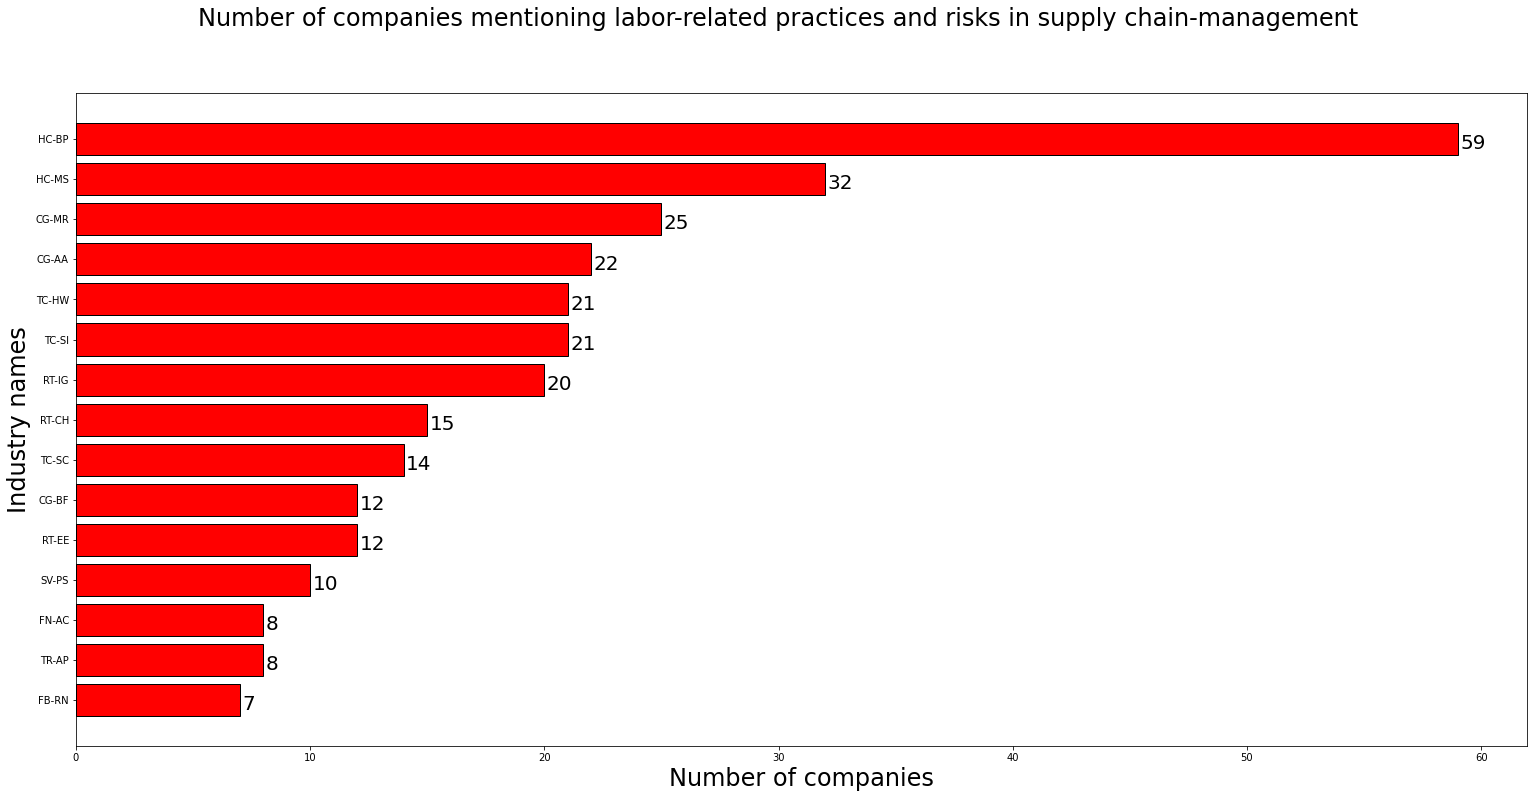

In [ ]:
plt.figure(figsize=(26,12))
plt.barh(ind_df['industry'],ind_df['flagged companies'], color='red', edgecolor='black')

for i, v in enumerate(ind_df['flagged companies']):
    plt.text(v + .1, i-.25, str(v), color='black',fontsize=20)

plt.suptitle('Number of companies mentioning labor-related practices and risks in supply chain-management', fontsize=24)
plt.xlabel('Number of companies', fontsize=24)
plt.ylabel('Industry names', fontsize=24)
plt.savefig('numcomp_chart.png')

**Extension: Exhibit B**

Graph of the percentage of 10-K's in each industry in TVL that are related to labor practices
- Same question above about if this includes labor-related risks.
- Is this the percentage of paragraphs that are related to practices or percentage of 10-K's (I ask because I assume a graph of the shares of 10-K's relating to practices will be 100% whereas the shares on a paragraph level will provide a more reasonable number if I'm not mistaken)

In [ ]:
pct_df = ind_df
pct_df['total pct flagged'] = (ind_df['flagged companies']/ind_df['total companies'])
pct_df = pct_df.sort_values(by=['total pct flagged'],ascending=True)
pct_df = pct_df[-15:]

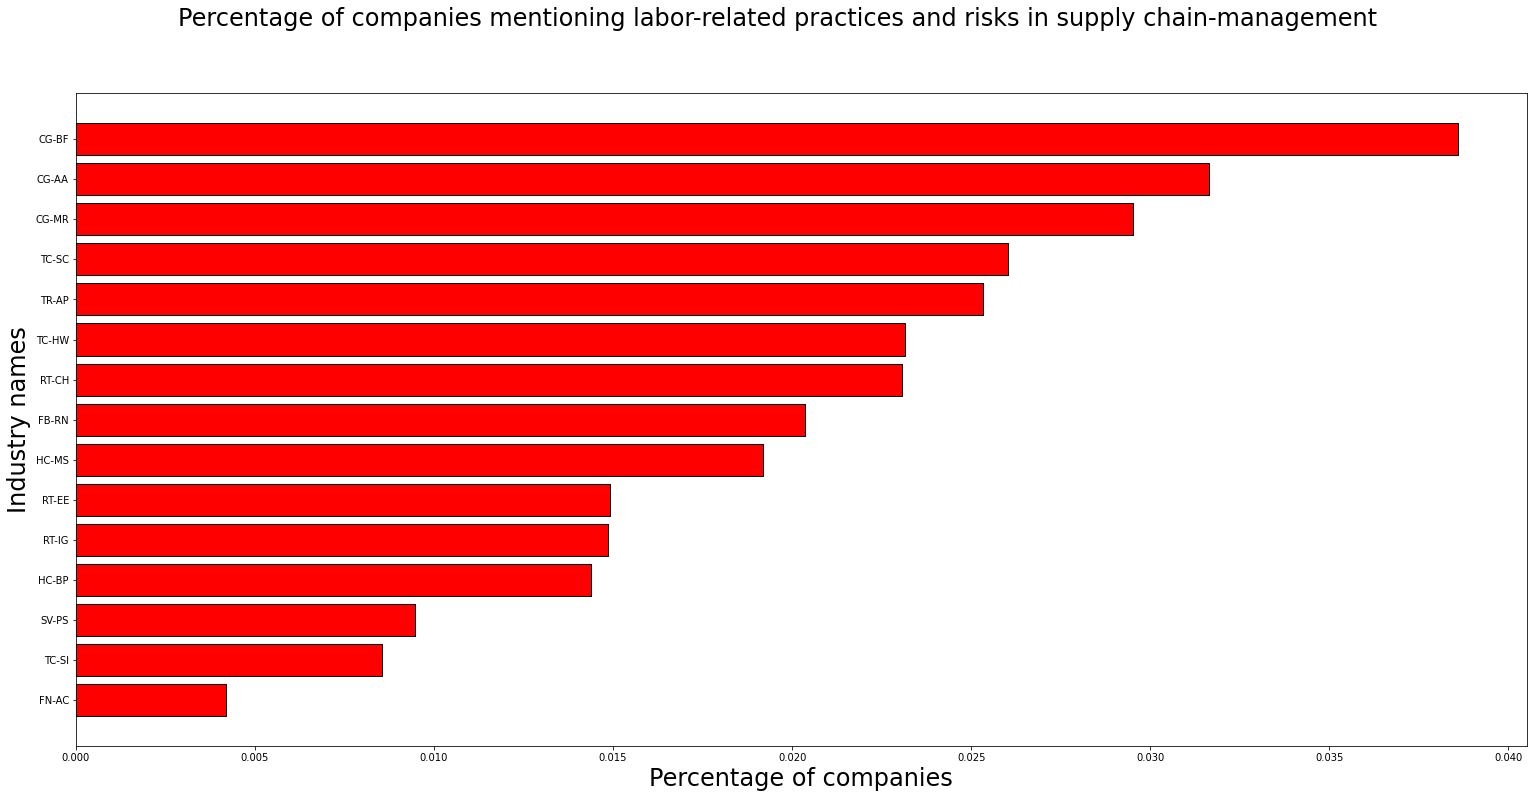

In [ ]:
plt.figure(figsize=(26,12))
plt.barh(pct_df['industry'],pct_df['total pct flagged'], color='red', edgecolor='black')

#for i, v in enumerate(ind_df['total pct flagged']):
    #plt.text(v + .1, i, str(v), color='black',fontsize=20)

plt.suptitle('Percentage of companies mentioning labor-related practices and risks in supply chain-management', fontsize=24)
plt.xlabel('Percentage of companies', fontsize=24)
plt.ylabel('Industry names', fontsize=24)
plt.savefig('pct_chart.png')

**Addition: Exhibit 1**

List sorted in descending order where each line is an industry-practice combination and the value is the number of articles that have that practice term in that industry and co-occur with a risk term, top 10.